In [215]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

In [216]:
local_path = '/Users/mikkelrasmussen/mnt/deep_learning_project/data/'
single_img_path = 'singh_cp_pipeline_singlecell_images'
plate = 'Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3-DBD0C40B78DB'
single_cell_img = 'Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3-DBD0C40B78DB'

In [ ]:
## segmented single cell images
idx = random.sample(range(1, 200), 9)
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        single_cell_image = np.load(os.path.join(local_path, single_img_path, plate, single_cell_img + '_{}.npy'.format(idx[(i-1)*3+j])))
        axs[i, j].imshow(single_cell_image/single_cell_image.max(axis=(0,1)))

In [ ]:
## dapi channel of segmented single cell images
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        single_cell_dapi_image = np.load(os.path.join(local_path, single_img_path, plate, single_cell_img + '_{}.npy'.format(idx[(i-1)*3+j])))[:,:,0]
        axs[i, j].imshow(single_cell_dapi_image, cmap = 'gray')

In [ ]:
## actin channel of segmented single cell images
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        single_cell_actin_image = np.load(os.path.join(local_path, single_img_path, plate, single_cell_img + '_{}.npy'.format(idx[(i-1)*3+j])))[:,:,1]
        axs[i, j].imshow(single_cell_actin_image, cmap = 'gray')

In [ ]:
## Tubulin channel of segmented single cell images
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        single_cell_tubulin_image = np.load(os.path.join(local_path, single_img_path, plate, single_cell_img + '_{}.npy'.format(idx[(i-1)*3+j])))[:,:,2]
        axs[i, j].imshow(single_cell_tubulin_image, cmap = 'gray')

In [210]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import time
import re

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, RandomSampler
import seaborn as sns

import glob

In [8]:
start_time = time.time()
metadata = pd.read_csv('../data/metadata.csv', engine="pyarrow")
print("pd.read_csv wiht pyarrow took %s seconds" % (time.time() - start_time))

pd.read_csv wiht pyarrow took 1575.6575388908386 seconds


In [ ]:
import dask.dataframe as dd
df = dd.read_csv('../data/metadata.csv')

In [211]:
metadata

,,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488391,488391,3839,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,69,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,9,3600,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,Week9_39301,Week9_090907_G11_s4_w22E574F48-321D-4470-ACC4-...,Week9_39301,Week9_090907_G11_s4_w4200C5003-7F75-47DF-928C-...,Week9_39301,Week9_39301,G11,3,DMSO,0.0,DMSO
488392,488392,3839,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,70,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,9,3600,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,Week9_39301,Week9_090907_G11_s4_w22E574F48-321D-4470-ACC4-...,Week9_39301,Week9_090907_G11_s4_w4200C5003-7F75-47DF-928C-...,Week9_39301,Week9_39301,G11,3,DMSO,0.0,DMSO
488393,488393,3839,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,71,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,9,3600,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,Week9_39301,Week9_090907_G11_s4_w22E574F48-321D-4470-ACC4-...,Week9_39301,Week9_090907_G11_s4_w4200C5003-7F75-47DF-928C-...,Week9_39301,Week9_39301,G11,3,DMSO,0.0,DMSO
488394,488394,3839,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,72,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,9,3600,Week9_090907_G11_s4_w1C447A151-1F85-4E19-9C96-...,Week9_39301,Week9_090907_G11_s4_w22E574F48-321D-4470-ACC4-...,Week9_39301,Week9_090907_G11_s4_w4200C5003-7F75-47DF-928C-...,Week9_39301,Week9_39301,G11,3,DMSO,0.0,DMSO


In [212]:
DMSO_indx = metadata.index[metadata['moa'] == 'DMSO']
DMSO_drop_indices = np.random.choice(DMSO_indx, size=260360, replace=False)

metadata_subsampled = metadata.drop(DMSO_drop_indices).reset_index()

In [185]:
# Map from class name to class index
classes = {index: name for name, index in enumerate(metadata["moa"].unique())}
classes

{'DMSO': 0,
 'Microtubule stabilizers': 1,
 'Eg5 inhibitors': 2,
 'Epithelial': 3,
 'Actin disruptors': 4,
 'Microtubule destabilizers': 5,
 'Aurora kinase inhibitors': 6,
 'Protein degradation': 7,
 'DNA replication': 8,
 'DNA damage': 9,
 'Protein synthesis': 10,
 'Kinase inhibitors': 11,
 'Cholesterol-lowering': 12}

In [186]:
classes_inv = {v: k for k, v in classes.items()}
classes_inv

{0: 'DMSO',
 1: 'Microtubule stabilizers',
 2: 'Eg5 inhibitors',
 3: 'Epithelial',
 4: 'Actin disruptors',
 5: 'Microtubule destabilizers',
 6: 'Aurora kinase inhibitors',
 7: 'Protein degradation',
 8: 'DNA replication',
 9: 'DNA damage',
 10: 'Protein synthesis',
 11: 'Kinase inhibitors',
 12: 'Cholesterol-lowering'}

In [191]:
#######################################################
#               Define Dataset Class
#######################################################
train_transforms = transforms.Compose(
    [transforms.ToTensor()]
)

class SingleCellDataset(torch.utils.data.Dataset):
    def __init__(self, annotation_file, images_folder, transform = None):
        self.df = annotation_file
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = classes

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        filename = self.df.loc[index, "Single_Cell_Image_Name"]
        label = self.class2index[self.df.loc[index, "moa"]]
        subfolder = re.search("(.*)_", filename).group(1)
        image = np.load(os.path.join(self.images_folder, subfolder, filename))
        if self.transform is not None:
            image = self.transform(image.astype("int16"))
        return image, label

In [206]:
#######################################################
#                  Create Dataset
#######################################################
images_folder = "../data/singh_cp_pipeline_singlecell_images"
# Full dataset
train_set = SingleCellDataset(images_folder=images_folder, 
                              annotation_file=metadata, 
                              transform=train_transforms)
# Subsampled dataset - DMSO class undersampled
train_set_subsampled = SingleCellDataset(images_folder=images_folder, 
                                         annotation_file=metadata_subsampled, 
                                         transform=train_transforms)

In [198]:
#######################################################
#                  Define Dataloaders
#######################################################
batch_size = 25  # both for training and testing
sampler = RandomSampler(train_set, replacement=False, num_samples=100)
train_loader = DataLoader(train_set, sampler=sampler, batch_size=batch_size, drop_last=True)

In [199]:
metadata.groupby("moa").size().reset_index(name='counts').sort_values(by="counts", ascending=False)

,moa,counts
3,DMSO,276360
10,Microtubule stabilizers,89157
1,Aurora kinase inhibitors,16810
4,DNA damage,16582
9,Microtubule destabilizers,15178
7,Epithelial,14955
6,Eg5 inhibitors,12525
8,Kinase inhibitors,11622
12,Protein synthesis,9715
0,Actin disruptors,7491


In [200]:
metadata_subsampled.groupby("moa").size().reset_index(name='counts').sort_values(by="counts", ascending=False)

,moa,counts
10,Microtubule stabilizers,89157
1,Aurora kinase inhibitors,16810
4,DNA damage,16582
3,DMSO,16000
9,Microtubule destabilizers,15178
7,Epithelial,14955
6,Eg5 inhibitors,12525
8,Kinase inhibitors,11622
12,Protein synthesis,9715
0,Actin disruptors,7491


<Figure size 200x1000 with 0 Axes>

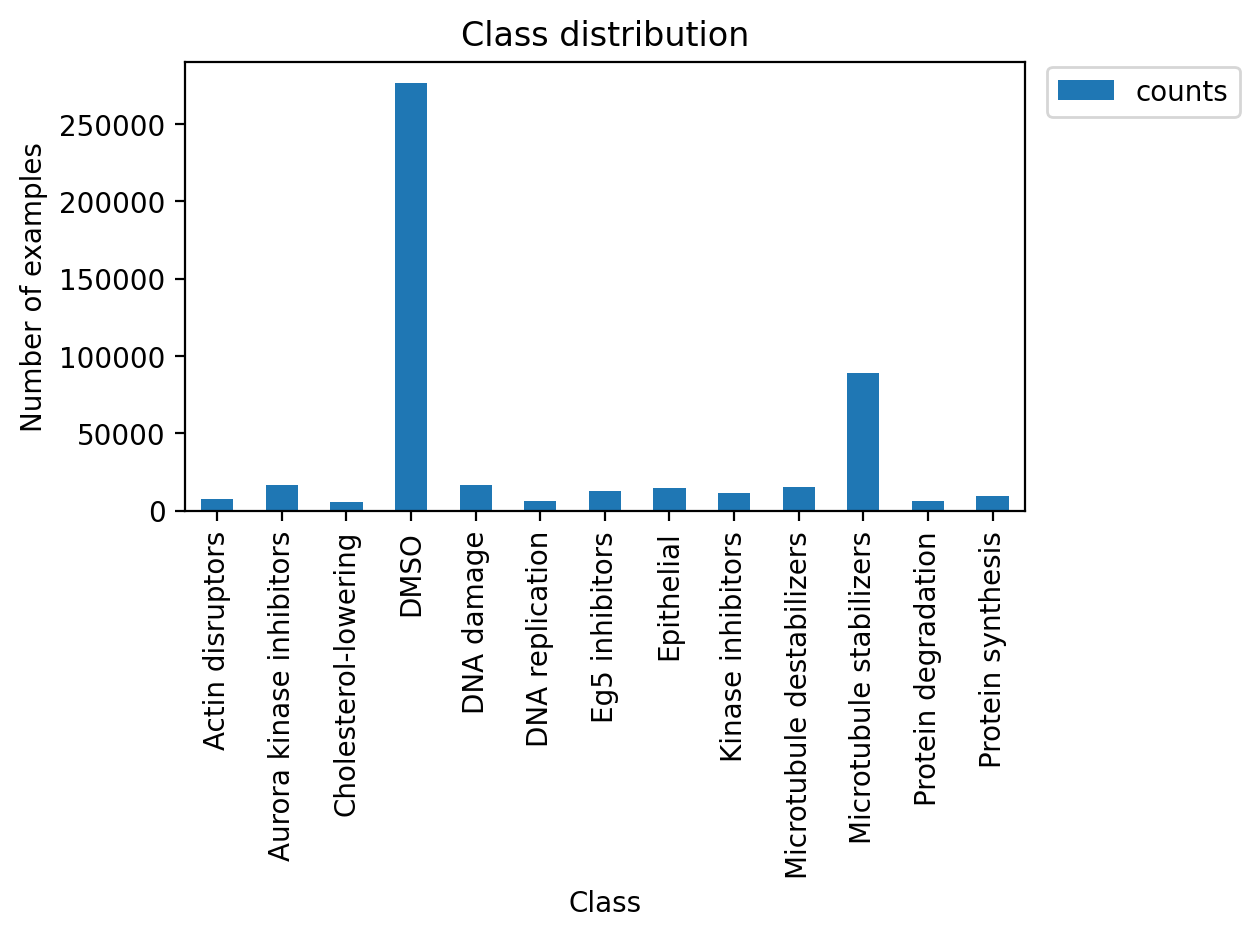



Train images:


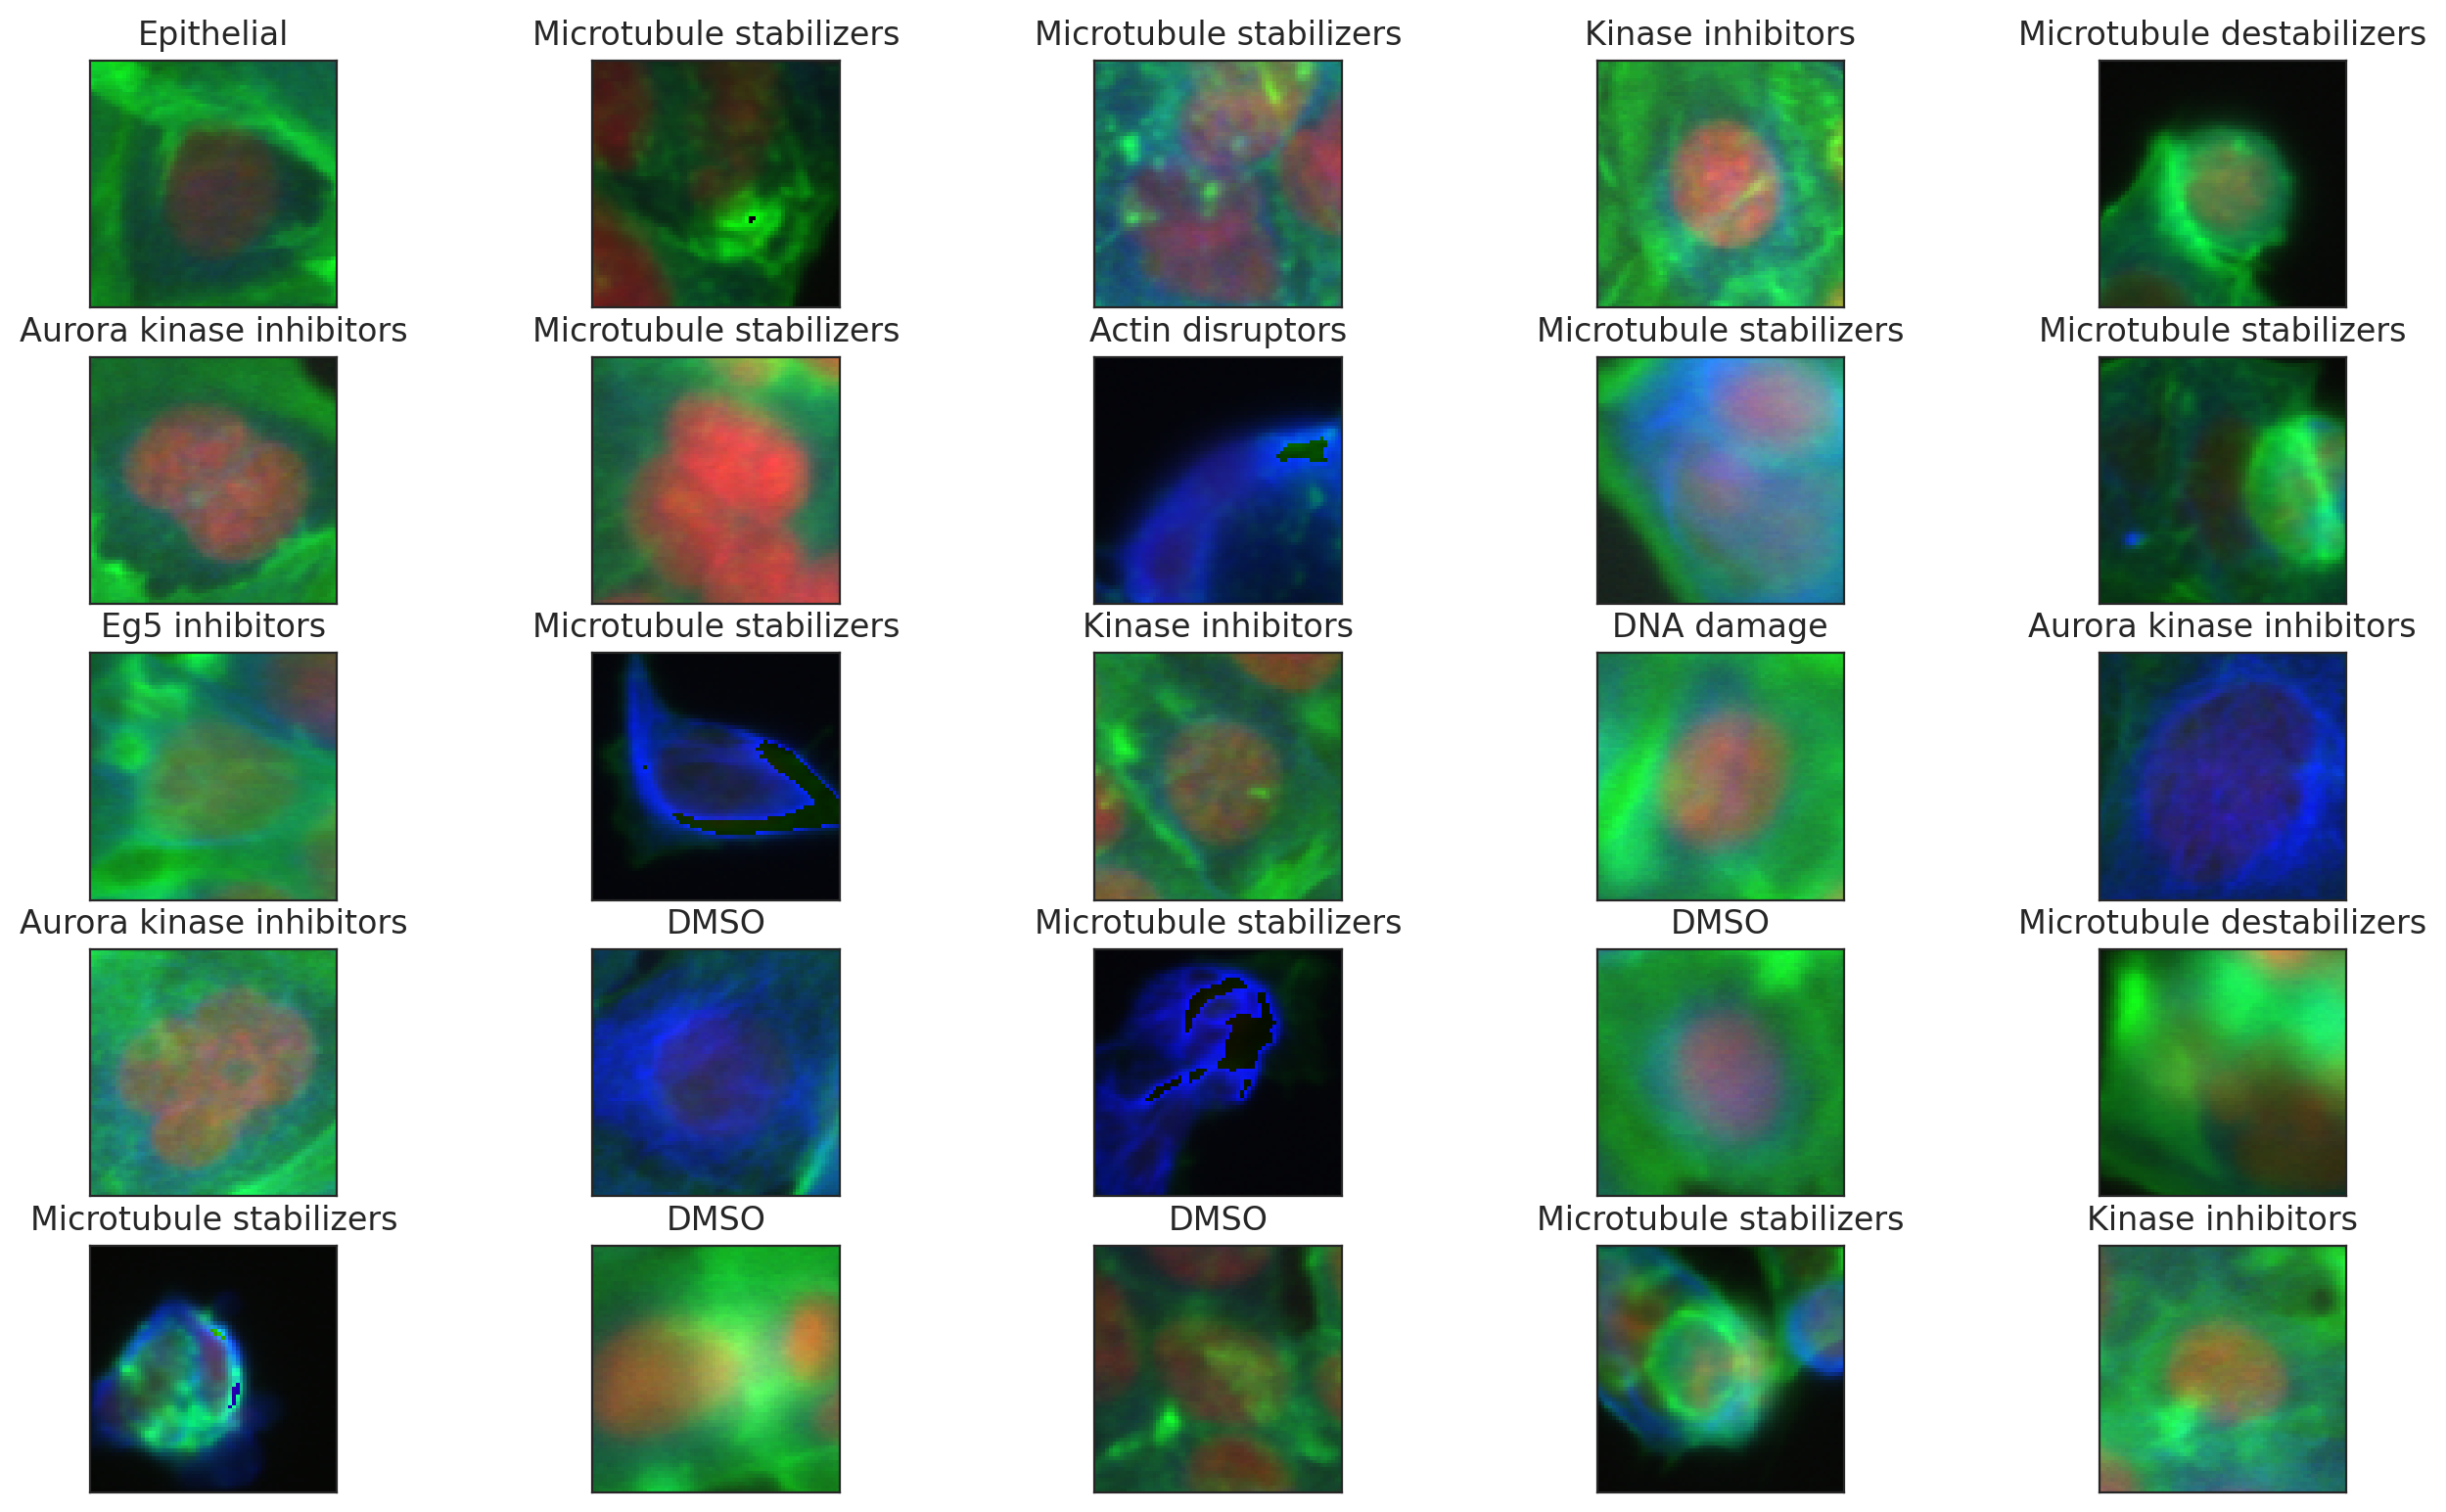

In [201]:
labels_unique, counts = np.unique(metadata["moa"], return_counts=True)
plt.figure(figsize=(2, 10))
df = pd.DataFrame({'counts' : counts},
                  index=labels_unique)
df.plot(kind="bar", stacked=True)
#df.T.plot.bar(stacked=True, rot=0, cmap='tab20')
plt.legend(bbox_to_anchor=(1.01, 1.02), loc='upper left')
#sns.barplot(x=labels_unique, y=counts, color=sns.color_palette('muted')[0])
plt.xticks(rotation=90)
plt.xlabel("Class")
plt.ylabel("Number of examples")
plt.title("Class distribution")
plt.tight_layout()
plt.show()

def show_image(img, title=None):
    img = img.detach().cpu()
    img = img/img.max()
    img = img.permute((1, 2, 0)).numpy()
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)


def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
        fig, axes = plt.subplots(5, 5, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:32], labels[:32])):
        plt.sca(axes[j])
        show_image(img, title=f"{classes_inv[label.item()]}")
    plt.show()


print("\n\nTrain images:")
show_dataset_examples(train_loader)

#### Alternative

We could use WeightedRandomSampler (or maybe: https://github.com/ufoym/imbalanced-dataset-sampler) instead of down-sampling.

In [214]:
print("Unique labels {}".format(labels))
class_weights = {l: sum(counts) / c for l, c in zip(labels_unique, counts)}
# Assign weights to each input sample
example_weights = [class_weights[e] for e in metadata["moa"]]
sampler = WeightedRandomSampler(example_weights, len(metadata["moa"]))
train_dataloader = DataLoader(train_set, sampler=sampler, 
                              batch_size=batch_size, drop_last=True)

Unique labels ['DMSO', 'Microtubule stabilizers', 'Eg5 inhibitors', 'Kinase inhibitors']


#### References

- https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895
- https://stackoverflow.com/questions/60127632/load-multiple-npy-files-size-10gb-in-pytorch
- https://stackoverflow.com/questions/65231299/load-csv-and-image-dataset-in-pytorch
- https://towardsdatascience.com/address-class-imbalance-easily-with-pytorch-e2d4fa208627
- https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
